In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import sys,os  # Import sys module for path manipulation
sys.path.append(r"../method")  # Add parent directory to system
import Calibration as cb
import resize as r
chesspath=r"../data/chessboard.jpg"
chesscampath=r"../data/OpenCVtabletorecognize1.jpeg"
markersX = 9           #X轴上标记的数量
markersY = 6          #EY轴上标记的数量

square_size=10
board_size = (markersX, markersY)


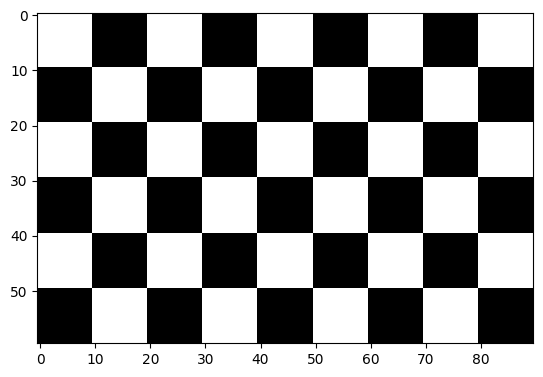

In [3]:
c=cb.Chess(board_size, square_size)
# 生成棋盘格
chessboard = c.generateChessboard()
#cv2.imwrite(chesspath, chessboard)
r.show(chessboard)

In [4]:
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# print(cv2.TERM_CRITERIA_EPS,'',cv2.TERM_CRITERIA_MAX_ITER)
img = cv2.imread(chesscampath)
# Color-segmentation to get the binary mask
lower_blue = np.array([0, 0, 0], dtype=np.uint8)
upper_blue = np.array([255, 255, 255], dtype=np.uint8)
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv, lower_blue, upper_blue)
gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# 1. 调整亮度和对比度以获得更清晰的棋盘格
gray = cv2.convertScaleAbs(gray, alpha=1.5, beta=0)
# 2. 使用自适应阈值化来获得更清晰的棋盘格
thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,11,2)
# 3. 高斯模糊来减少噪声
blur = cv2.GaussianBlur(gray,(5,5),0)
# 4. 调整findChessboardCorners的参数,如改变角点数量,提高质量级别等


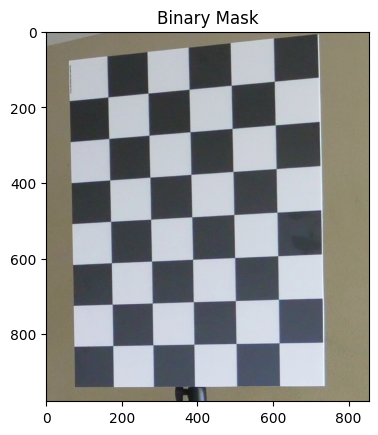

In [5]:
res = cv2.bitwise_and(img, img, mask=mask)
r.plt_show( "Binary Mask",res)


In [6]:
img = cv2.imread(chesscampath)
board_size=(7,5)


In [7]:
ret=True
corners=c.find_corners_sb(img,board_size)
corners_idx = np.array([0, markersX * (markersY - 1), (markersX - 1) * markersY, markersX * markersY - 1])
corners3 = np.array([])
corners3 = corners[corners_idx]
# 将角点在图像上显示
cv2.drawChessboardCorners(img, (markersX, markersY), corners3, ret)
r.show(img)



IndexError: index 45 is out of bounds for axis 0 with size 35

[[[604.47186 133.51059]]

 [[164.36754 175.27806]]

 [[169.30699 394.43713]]

 [[177.28043 832.3985 ]]]


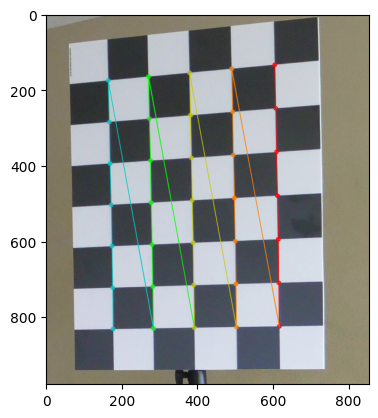

In [ ]:
markersX = 7
markersY = 5

# 如果找到足够点对，将其存储起来


if ret == True:
    #精确找到角点坐标
    corners2 = cv2.cornerSubPix(gray,corners,(markersX,markersY),(-1,-1),criteria)
    corners_idx = np.array([0, markersX * (markersY - 1), (markersX - 1) * markersY, markersX * markersY - 1])
    corners3 = corners[corners_idx]
    # 将角点在图像上显示
    cv2.drawChessboardCorners(img, (markersX, markersY), corners2, ret)
    print(corners3)
    # cv2.imshow('findCorners',img)
    # cv2.waitKey()
# cv2.destroyAllWindows()
r.show(img)


In [ ]:
# print('四个点的坐标是:\n',corners3)
point = np.reshape(corners3,(4,2))
print(point)

dst = np.array([[200, 200],
                [400, 200],
                [200, 400],
                [400, 400]], dtype = "float32")
M = cv2.getPerspectiveTransform(point, dst)
print('变换矩阵是', M)
warped = cv2.warpPerspective(img, M, (1000, 1000))

img = cv2.resize(img,(400,400))
cv2.imshow('img',img)
cv2.imshow('fin',warped)


In [ ]:
# 检测gray中的棋盘格并输出所有角点的图片
ret, corners = cv2.findChessboardCorners(gray, (markersX, markersY))

if ret == True:
    corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
    corners3 = np.array([corners[0], corners[10], corners[77], corners[87]])
    cv2.drawChessboardCorners(img, (2, 2), corners3, ret)
    cv2.imshow('Chessboard Corners', img)
    cv2.waitKey(0)


error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\calib3d\src\calibinit.cpp:506: error: (-211:One of the arguments' values is out of range) Both width and height of the pattern should have bigger than 2 in function 'cv::findChessboardCorners'


In [ ]:
def find_homography(image1, image2):
  """
  使用 SIFT 特征匹配和 RANSAC 算法计算图像之间的单应性矩阵

  Args:
    image1: 第一幅图像
    image2: 第二幅图像

  Returns:
    单应性矩阵
  """

  # 初始化 SIFT 特征提取器和匹配器
  sift = cv2.SIFT_create()
  bf = cv2.BFMatcher()

  # 提取特征点和描述符
  kp1, des1 = sift.detectAndCompute(image1, None)
  kp2, des2 = sift.detectAndCompute(image2, None)

  # 进行特征点匹配
  matches = bf.knnMatch(des1, des2, k=2)

  # 使用 RANSAC 算法筛选出好的匹配点
  good_matches = []
  for m, n in matches:
    if m.distance < 0.75 * n.distance:
      good_matches.append(m)

  # 计算单应性矩阵
  H, _ = cv2.findHomography(np.array([kp1[m.queryIdx].pt for m in good_matches]),
                          np.array([kp2[m.trainIdx].pt for m in good_matches]),
                          cv2.RANSAC, 5.0)

  return H

# 读取图像
image1 = cv2.imread("data/chessboard.jpg")
image2 = cv2.imread("..\Aruco\gc_0051.png")

# 计算单应性矩阵
H = find_homography(image1, image2)

# 进行图像配准
warped = cv2.warpPerspective(image1, H, (image2.shape[1], image2.shape[0]))

# 显示结果
plt.subplot(121)
plt.imshow(image1)
plt.title("Image 1")

plt.subplot(122)
plt.imshow(warped)
plt.title("Warped Image")

plt.show()


In [ ]:
import cv2
import numpy as np

def detect_chessboard_corners(image, pattern_size):
    """
    使用 OpenCV 查找棋盘角点

    参数：
        image: 输入图像
        pattern_size: 棋盘图案大小，例如 (7, 8) 表示棋盘有 7 行 8 列角点

    返回值：
        如果找到角点，则返回角点坐标列表；否则，返回空列表
    """

    # gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # # 使用局部自适应阈值化二值化图像
    # ret, thresh = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY_ADAPTIVE_MEAN_C)

    # # 使用形态学操作去除噪声
    # kernel = np.ones((3, 3), np.uint8)
    # thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    thresh=image

    # 查找棋盘角点
    corners, _ = cv2.findChessboardCorners(thresh, pattern_size, None)

    if corners is not None:
        # 使用亚像素精度改进角点位置
        criteria = cv2.TermCriteria(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.1)
        corners = cv2.cornerSubPix(thresh, corners, (5, 5), criteria)

        return corners.tolist()
    else:
        return []

# 读取图像
image = chessboard
# 检测棋盘角点
corners = detect_chessboard_corners(image, (7, 8))

# 绘制角点
if corners:
    for corner in corners:
        cv2.circle(image, tuple(int(p) for p in corner), 5, (0, 255, 0), -1)

    # 显示结果
    cv2.imshow('result', image)
    cv2.waitKey(0)
else:
    print('未找到棋盘角点')
